In [1]:
import requests
import pandas as pd
import time
import os
from matplotlib_venn import venn2

In [ ]:
# Load in the full, specific, aspecific, and undecided fractions for LMCD1 as determined by the Sala methodology. 

import pandas as pd

lmcd1_full = pd.read_excel("G:/My Drive/Uni/Thesis/Data/Testin_for_TVB/LMCD1 + TesCR/lmcd1_data/Stefano_EXT983_LMCD1_FL.xlsx", sheet_name = 'proteins')
lmcd1_specific = pd.read_csv("G:/My Drive/Uni/Thesis/Data/datasets_cutoff/sala_venn_cutoffs/Stefano_EXT983_LMCD1_FL_specific_cutoff.csv")
lmcd1_aspecific = pd.read_csv("G:/My Drive/Uni/Thesis/Data/datasets_cutoff/sala_venn_cutoffs/Stefano_EXT983_LMCD1_FL_aspecific_cutoff.csv")
lmcd1_undecided = pd.read_csv("G:/My Drive/Uni/Thesis/Data/datasets_cutoff/sala_venn_cutoffs/Stefano_EXT983_LMCD1_FL_undecided_cutoff.csv")

In [ ]:
# Step 1: fetch the known interactions for the specific or aspecific datasets.

def fetch_biogrid_interactions(input_dataset, acces_key="2c48a1ace1f16d534f59f559323a8eb0", tax_id=9606):
    """
    Fetch interactions for genes in the input dataset using the BioGRID API.
    
    Parameters:
    input_dataset (DataFrame): Input dataset containing a column 'accession' with gene names. Typically this is the dataset with genes above (aspecific) or below (specific) the cutoff.
    acces_key (str): BioGRID API access key. This can be freely requested from BioGRID on the website (default is my own key).
    tax_id (int): Taxonomy ID for species (default is 9606 for human).
    
    Returns:
    DataFrame: Dataframe containing BioGRID interactions of all the proteins in the input dataset.
    """
    base_url = "https://webservice.thebiogrid.org"
    request_url = base_url + "/interactions"

    # List of genes to search for
    gene_list = input_dataset["accession"].tolist()
    evidence_list = ["POSITIVE GENETIC", "PHENOTYPIC ENHANCEMENT", "Reconstituted Complex"]

    all_results = pd.DataFrame()
    start = 0
    max_results = 10000

    while True:
        # Parameters for BioGRID API
        params = {
            "accesskey": acces_key,
            "format": "json",
            "geneList": "|".join(gene_list),
            "searchNames": "true",
            "includeInteractors": "true",
            "taxId": tax_id,
            "evidenceList": "|".join(evidence_list),
            "includeEvidence": "false",
            "includeHeader": "true",
            "interSpeciesExcluded": "true",
            "additionalIdentifierTypes": "UNIPROT|UNIPROTKB",
            "start": start,
            "max": max_results
        }

        # Send request to BioGRID API
        response = requests.get(request_url, params=params)
        response.raise_for_status()
        interactions = response.json()

        # Create a dictionary of results by interaction identifier
        data = {}
        for interaction_id, interaction in interactions.items():
            data[interaction_id] = interaction
            data[interaction_id]["INTERACTION_ID"] = interaction_id

        # Load the data into a pandas dataframe
        dataset = pd.DataFrame.from_dict(data, orient="index")
        all_results = pd.concat([all_results, dataset], ignore_index=True)

        # Check if we received fewer results than the maximum, indicating the end
        if len(dataset) < max_results:
            break

        # Update the start parameter for the next batch
        start += max_results

    # Select only the desired columns
    columns = [
        "INTERACTION_ID",
        "ENTREZ_GENE_A",
        "ENTREZ_GENE_B",
        "OFFICIAL_SYMBOL_A",
        "OFFICIAL_SYMBOL_B",
        "EXPERIMENTAL_SYSTEM",
        "PUBMED_ID",
        "PUBMED_AUTHOR",
        "THROUGHPUT",
        "QUALIFICATIONS",
    ]
    interactor_dataset = all_results[columns]

    return interactor_dataset


In [4]:
# Generate the BioGRID interaction datasets for LMCD1's specific and aspecific datasets.
lmcd1_aspecific_int = fetch_biogrid_interactions(lmcd1_aspecific)
lmcd1_specific_int = fetch_biogrid_interactions(lmcd1_specific)

In [ ]:
# Step 2: map UniProt accession codes to Entrez Gene IDs using UniProt API for the undecided dataset. 
# (Such that it can be compared to the interactor datasets which use entrez as ID)

def map_uniprot_to_entrez(undecided_dataset, batch_size=10):
    """
    Map UniProt accession codes to Entrez Gene IDs using UniProt API.

    Parameters:
    undecided_dataset (DataFrame): Input dataset containing a column 'accession' with UniProt IDs.
    acces_key (str): UniProt API access key.
    batch_size (int): Size of batches for submitting ID mapping jobs. Larger batches may be faster but hit API limits.

    Returns:
    DataFrame: Updated dataset with an added column 'entrez_gene_id'.
    """
    def submit_id_mapping(uniprot_ids):
        url = "https://rest.uniprot.org/idmapping/run"
        payload = {
            'from': 'UniProtKB_AC-ID',
            'to': 'Gene_Name',
            'ids': ','.join(uniprot_ids)
        }
        response = requests.post(url, data=payload)
        response.raise_for_status()
        result = response.json()

        if "jobId" in result:
            return result["jobId"]
        elif "results" in result:
            return pd.DataFrame(result['results'])
        raise Exception(f"Unexpected response format: {result}")

    def get_mapping_results(job_id):
        results_url = f"https://rest.uniprot.org/idmapping/results/{job_id}"
        max_retries = 30
        retry_count = 0
        while retry_count < max_retries:
            response = requests.get(results_url)
            if response.status_code == 404:
                print(f"Results not ready yet, retrying... ({retry_count + 1}/{max_retries})")
                retry_count += 1
                time.sleep(2)
                continue
            response.raise_for_status()
            results = response.json()
            if "results" in results:
                return pd.DataFrame(results['results'])
            elif "jobStatus" in results and results["jobStatus"] == "FINISHED":
                retry_count += 1
                time.sleep(5)
            elif "jobStatus" in results and results["jobStatus"] == "RUNNING":
                print(f"Job is still running, retrying... ({retry_count + 1}/{max_retries})")
                retry_count += 1
                time.sleep(2)
        raise Exception(f"Job did not complete after {max_retries} retries")

    uniprot_ids = undecided_dataset['accession'].unique()
    total_batches = (len(uniprot_ids) + batch_size - 1) // batch_size
    print(f"Total batches to process: {total_batches}")

    all_results = pd.DataFrame()

    for i in range(0, len(uniprot_ids), batch_size):
        batch = uniprot_ids[i:i + batch_size]
        print(f"Processing batch {i//batch_size + 1} of {total_batches}: {len(batch)} IDs")
        job_id = submit_id_mapping(batch)
        try:
            batch_results = get_mapping_results(job_id)
            all_results = pd.concat([all_results, batch_results], ignore_index=True)
        except Exception as e:
            print(f"Failed to process batch {i//batch_size + 1}: {e}")

    undecided = undecided_dataset.merge(all_results, left_on='accession', right_on='from', how='left')
    undecided.rename(columns={'to': 'entrez_gene_id'}, inplace=True)

    return undecided

In [ ]:
# Generate a dataframe which contains the undecided proteins with their Entrez Gene IDs.
lmcd1_undecided_entrez = map_uniprot_to_entrez(lmcd1_undecided)

Total batches to process: 84
Processing batch 1 of 84: 10 IDs
Processing batch 2 of 84: 10 IDs
Processing batch 3 of 84: 10 IDs
Processing batch 4 of 84: 10 IDs
Processing batch 5 of 84: 10 IDs
Processing batch 6 of 84: 10 IDs
Processing batch 7 of 84: 10 IDs
Processing batch 8 of 84: 10 IDs
Processing batch 9 of 84: 10 IDs
Processing batch 10 of 84: 10 IDs
Processing batch 11 of 84: 10 IDs
Processing batch 12 of 84: 10 IDs
Processing batch 13 of 84: 10 IDs
Processing batch 14 of 84: 10 IDs
Processing batch 15 of 84: 10 IDs
Processing batch 16 of 84: 10 IDs
Processing batch 17 of 84: 10 IDs
Processing batch 18 of 84: 10 IDs
Processing batch 19 of 84: 10 IDs
Processing batch 20 of 84: 10 IDs
Processing batch 21 of 84: 10 IDs
Processing batch 22 of 84: 10 IDs
Processing batch 23 of 84: 10 IDs
Processing batch 24 of 84: 10 IDs
Processing batch 25 of 84: 10 IDs
Processing batch 26 of 84: 10 IDs
Processing batch 27 of 84: 10 IDs
Processing batch 28 of 84: 10 IDs
Processing batch 29 of 84: 1

In [ ]:
# Venn function to show  overlap between interactors of specific or unspecific fractions and uncertain fractions.
# Incorporated in the find_matching_entries function.

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def plot_venn_interactors_overlap(name, interactors, undecided_entrez, save_path="G:/My Drive/Uni/Thesis/Data/datasets_cutoff/venn_interactors"):
    """
    Creates a customized Venn diagram to show overlaps between the interactors of either above or below datasets with the uncertain dataset.

    Parameters:
    - name: Name of the dataset for the Venn diagram title and the file name.
    - interactors: DataFrame containing the interactors with 'ENTREZ_GENE_A' and 'ENTREZ_GENE_B' columns.
    - undecided_entrez: DataFrame containing undecided entries with 'entrez_gene_id' column.
    - save_path: Path to save the Venn diagram.
    """
    # Convert 'accession' column to sets
    interactors_ids_A = set(interactors['OFFICIAL_SYMBOL_A'])
    interactors_ids_B = set(interactors['OFFICIAL_SYMBOL_B'])
    interactors_ids = interactors_ids_A.union(interactors_ids_B)
    undecided_ids = set(undecided_entrez['entrez_gene_id'])

    plt.figure(figsize=(8, 8))
    venn = venn2([interactors_ids, undecided_ids], 
                 set_labels=('Interactors', 'Undecided'))

    # Customize colors and alpha for each section
    patches = {
        '10': 'pink',    # Only in interactors
        '01': 'skyblue', # Only in undecided
        '11': 'lightgreen' # Intersection
    }
    
    for patch_id, color in patches.items():
        patch = venn.get_patch_by_id(patch_id)
        if patch:  # Only set properties if the patch exists
            patch.set_color(color)
            patch.set_alpha(0.5)
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

    # Add a title
    plt.title(f"Customized Overlap between Interactors and Undecided Entries of {name}")

    # Save the plot
    venn_save_path = os.path.join(save_path, name+"_venn_interactors.png")
    plt.savefig(venn_save_path)
    print(f"Venn diagram saved at {venn_save_path}")
    plt.show()


In [ ]:
# Step 3: Find matching entries between the undecided dataset and the interactor dataset of specific or aspecific and add matches to these sets accordingly.
# Plot the Venn diagram showing the overlap between the interactors of the specific or aspecific fractions and undecided entries (plot_venn_interactors_overlap function, defined above.)

def find_matching_entries(name, data, undecided, interactor_dataset):
    """
    Find matching entries between undecided and interactor dataset of 'above' or 'below' dataset and add them to the appropriate dataset.

    Parameters:
    Data (DataFrame): Dataset containing proteins data from either the specific or the aspecific fractions, as determined through the Sala method.
    Undecided (DataFrame): Dataset with UniProt accessions mapped to Entrez Gene IDs.
    interactor_dataset (DataFrame): Dataset containing interaction data with columns 'OFFICIAL_SYMBOL_A' and 'OFFICIAL_SYMBOL_B'.

    Returns:
    DataFrame: Updated lmcd1_above dataset with matching entries appended.
    Venn diagram showing the overlap between the interactors and undecided entries.
    """
    plot_venn_interactors_overlap(name, interactor_dataset, undecided)

    # Extract unique Entrez gene IDs from undecided dataset
    undecided_ids = set(undecided['entrez_gene_id'])

    # Extract interactors as a set of unique IDs
    interactors_ids_A = set(interactor_dataset['OFFICIAL_SYMBOL_A'])
    interactors_ids_B = set(interactor_dataset['OFFICIAL_SYMBOL_B'])
    interactors_ids = interactors_ids_A.union(interactors_ids_B)

    # Find the intersection between undecided IDs and interactors
    matching_ids = undecided_ids.intersection(interactors_ids)

    # Filter undecided rows that have matching IDs in interactors
    matching_entries = undecided[undecided['entrez_gene_id'].isin(matching_ids)]

    # Concatenate matching entries to the updated data
    updated_data = pd.concat([data, matching_entries], ignore_index=True)

    return updated_data

In [ ]:
# Step 3.5: find the remaining undecided data.
def find_remaining_undecided(full_data, above_updated, below_updated):
    """
    Finds the remaining undecided entries in the full dataset that are not present in either the
    above_updated or below_updated datasets.

    Parameters:
    - full_data: DataFrame containing the full dataset.
    - above_updated: DataFrame containing the aspecific entries after cross-referencing with interactors.
    - below_updated: DataFrame containing the specific entries afer cross-referencing with interactors.

    Returns:
    - DataFrame containing the remaining undecided entries.
    """
    # Combine 'above_updated' and 'below_updated' to create a set of entries to exclude
    combined_above_below = pd.concat([above_updated, below_updated])
    
    # Find the remaining undecided entries in 'full_data' that are not in 'combined_above_below'
    remaining_undecided = full_data[~full_data['accession'].isin(combined_above_below['accession'])]
    
    return remaining_undecided

Venn diagram saved at G:/My Drive/Uni/Thesis/Data/datasets_cutoff/venn_interactors\above_venn_interactors.png


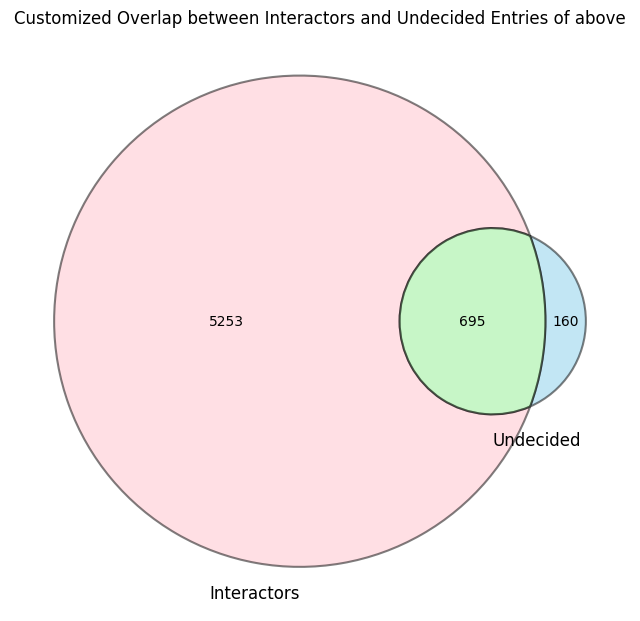

Venn diagram saved at G:/My Drive/Uni/Thesis/Data/datasets_cutoff/venn_interactors\below_venn_interactors.png


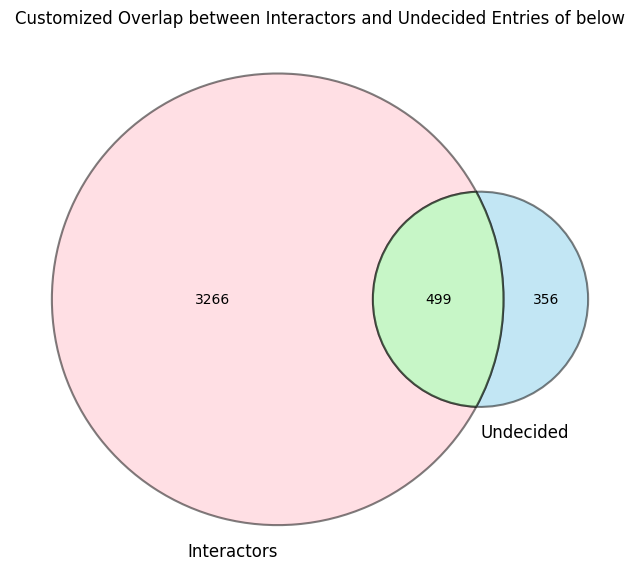

In [10]:
fl_aspecific_updated = find_matching_entries('above', lmcd1_aspecific, lmcd1_undecided_entrez, lmcd1_aspecific_int)
fl_specific_updated = find_matching_entries('below', lmcd1_specific, lmcd1_undecided_entrez, lmcd1_specific_int)
undecided_updated = find_remaining_undecided(lmcd1_full, fl_aspecific_updated, fl_specific_updated)

In [ ]:
# Venn function for overlap between updated fractions of above, below and undecided datasets. (same as plot_venn_cutoff but with updated datasets)
# Incorporated in find_unique_entries function below.

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3

def plot_updated_venn_cutoff(name, below_updated, undecided_updated, above_updated, save_path="G:/My Drive/Uni/Thesis/Data/datasets_cutoff/updated_venn_cutoffs"):
    """
    Creates a customized Venn diagram to show overlaps between three sets with color-matched labels.

    Parameters:
    - name: Name of the dataset for the Venn diagram title and the file name.
    - below: DataFrame containing the updated 'Below' entries.
    - undecided: DataFrame containing the updated 'Undecided' entries.
    - above: DataFrame containing the updated'Above' entries.
    - save_path: Path to save the Venn diagram.
    """
    # Convert 'accession' column to sets
    below_ids = set(below_updated['accession'])
    above_ids = set(above_updated['accession'])
    undecided_ids = set(undecided_updated['accession'])

    plt.figure(figsize=(8, 8))
    venn = venn3([below_ids, above_ids, undecided_ids], 
                 set_labels=('Below Updated', 'Above Updated', 'Undecided Updated'))

    # Customize colors and alpha for each section
    patches = {
        '100': 'pink',
        '010': 'skyblue',
        '001': 'lightgreen',
        '110': 'purple',
        '011': 'teal',
        '101': 'orange',
        '111': 'grey'
    }
    
    for patch_id, color in patches.items():
        patch = venn.get_patch_by_id(patch_id)
        if patch:  # Only set properties if the patch exists
            patch.set_color(color)
            patch.set_alpha(0.5)
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

    # Add a title
    plt.title("Overlap between the updated Specific (below), Aspecific (above), and Undecided Entries of "+name)

    # Save the plot
    venn_save_path = os.path.join(save_path, name+"_updated_venn_cutoff.png")
    plt.savefig(venn_save_path)
    print(f"Venn diagram saved at {venn_save_path}")
    plt.show()

In [ ]:
# Step 4: Function that finds the unique entries in the updated specific and aspecific datasets and returns duplicates to the undecided dataset.

def find_unique_entries(name, below_updated, above_updated, undecided_updated):
    """
    Find unique entries between below_updated, above_updated, and undecided_updated,
    and display a Venn diagram showing the overlap between the three datasets before and after the unique entries are found.

    Parameters:
    - below_updated (DataFrame): Dataset containing entries classified as below, after cross.
    - above_updated (DataFrame): Dataset containing entries classified as above.
    - undecided_updated (DataFrame): Dataset containing undecided entries with Entrez Gene IDs.

    Returns:
    - Tuple[DataFrame, DataFrame, DataFrame, DataFrame]: Four DataFrames containing unique entries:
        - Rows in below_updated but not in above_updated.
        - Rows in above_updated but not in below_updated.
        - Rows in undecided_updated that are not in either below_updated or above_updated.
    """
    # Plot the overlap between the three datasets using a Venn diagram before finding unique entries
    plot_updated_venn_cutoff(name+'_Initial_Overlap', below_updated, undecided_updated, above_updated)
    
    # Extract unique accessions from below and above datasets
    below_accessions = set(below_updated['accession'])
    above_accessions = set(above_updated['accession'])

    # Find unique entries
    below_not_in_above = below_updated[~below_updated['accession'].isin(above_accessions)]
    above_not_in_below = above_updated[~above_updated['accession'].isin(below_accessions)]

    # Extract unique accessions from the updated below and above datasets
    unique_accessions = below_accessions.union(above_accessions)

    # Find undecided entries that are not in either below or above
    undecided_not_in_below_or_above = undecided_updated[~undecided_updated['accession'].isin(unique_accessions)]

    # Find entries that are in both 'below_updated' and 'above_updated'
    common_entries = below_updated[below_updated['accession'].isin(above_accessions)]

    # Add these entries to the undecided dataset, ensuring no duplicates
    undecided_updated_2 = pd.concat([undecided_not_in_below_or_above, common_entries], ignore_index=True).drop_duplicates(subset='accession')

    # Plot the overlap between the three datasets using a Venn diagram after finding unique entries
    plot_updated_venn_cutoff(name+'Final_Overlap', below_not_in_above, undecided_updated_2, above_not_in_below)
    
    return below_not_in_above, above_not_in_below, undecided_updated_2



Venn diagram saved at G:/My Drive/Uni/Thesis/Data/datasets_cutoff/updated_venn_cutoffs\test_Initial_Overlap_updated_venn_cutoff.png


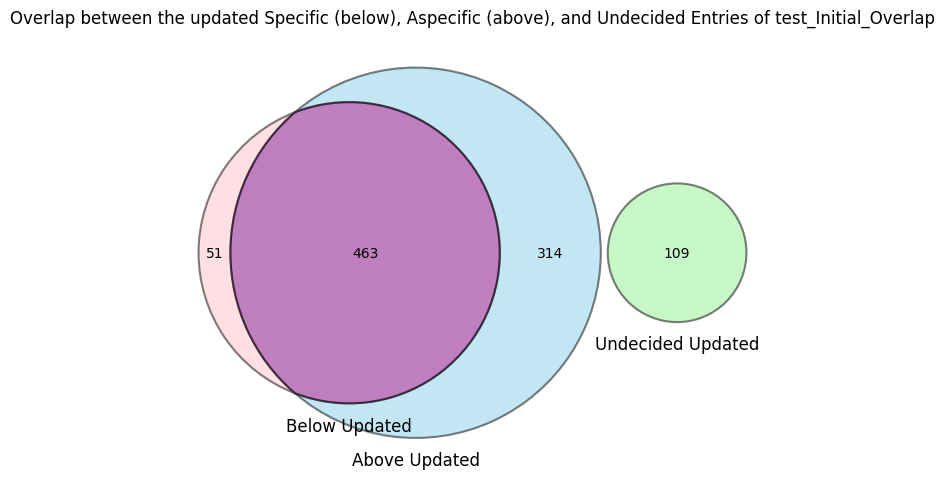

Venn diagram saved at G:/My Drive/Uni/Thesis/Data/datasets_cutoff/updated_venn_cutoffs\testFinal_Overlap_updated_venn_cutoff.png


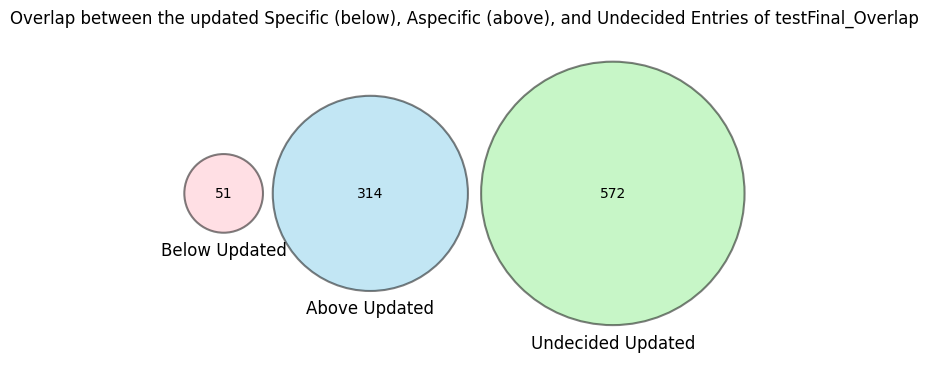

In [18]:
fl_below_unique, fl_above_unique, fl_undecided = find_unique_entries('test', fl_specific_updated, fl_aspecific_updated, undecided_updated)

In [ ]:
# Step 5: Plot the KDE distributions of the unique entries in the full dataset, specific unique, aspecific unique, and undecided unique datasets. This gives an insight of the distributions of the log2 ratios in these datasets.
import seaborn as sns
import matplotlib.pyplot as plt

def plot_kde_datasets(full_data, below_unique, above_unique, undecided_unique):
    """
    Creates KDE plots for the provided datasets to visualize the distributions of LOG2(L/H) ratios ( 'Median(log2(q.ratio)) )'.

    Parameters:
    - full_data (DataFrame): Full dataset containing 'Median(log2(q.ratio))'.
    - below_unique (DataFrame): DataFrame containing the unique specific entries.
    - above_unique (DataFrame): DataFrame containing the unique aspecific entries.
    - undecided_unique (DataFrame): DataFrame containing the undecided entries.
    """
    # Create KDE plot for the full dataset
    plt.figure(figsize=(12, 6))
    sns.kdeplot(full_data['Median(log2(q.ratio))'], label='LMCD1 Full', fill=True)
    plt.title('KDE Plot of Median(log2(q.ratio)) for LMCD1 Full Dataset')
    plt.xlabel('Median(log2(q.ratio))')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Create KDE plots for the below, above, and undecided unique datasets
    plt.figure(figsize=(12, 6))
    sns.kdeplot(below_unique['Median(log2(q.ratio))'], label='Below Unique', fill=True)
    sns.kdeplot(above_unique['Median(log2(q.ratio))'], label='Above Unique', fill=True)
    sns.kdeplot(undecided_unique['Median(log2(q.ratio))'], label='Undecided', fill=True)
    plt.title('KDE Plot of Median(log2(q.ratio)) for Below, Above, and Undecided Unique Entries')
    plt.xlabel('Median(log2(q.ratio))')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


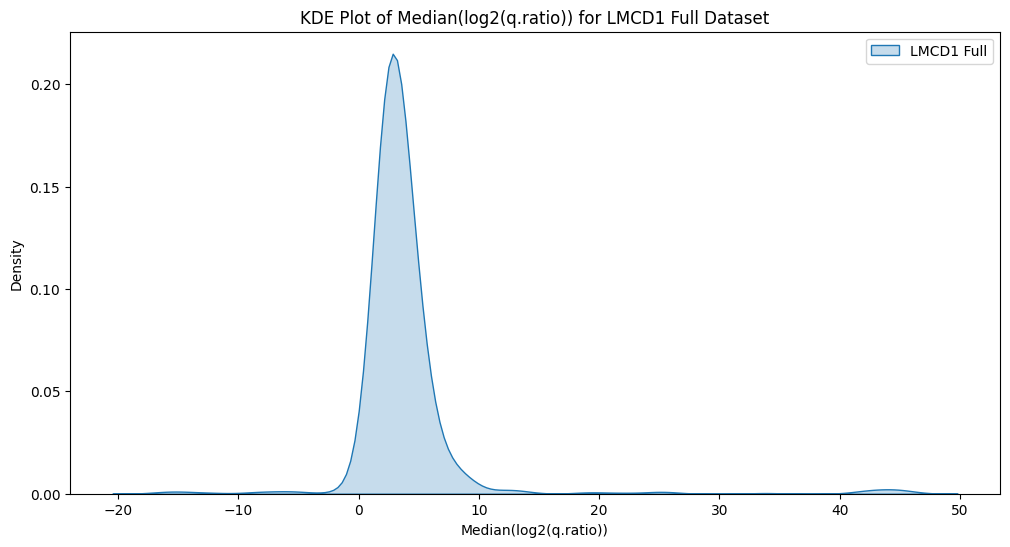

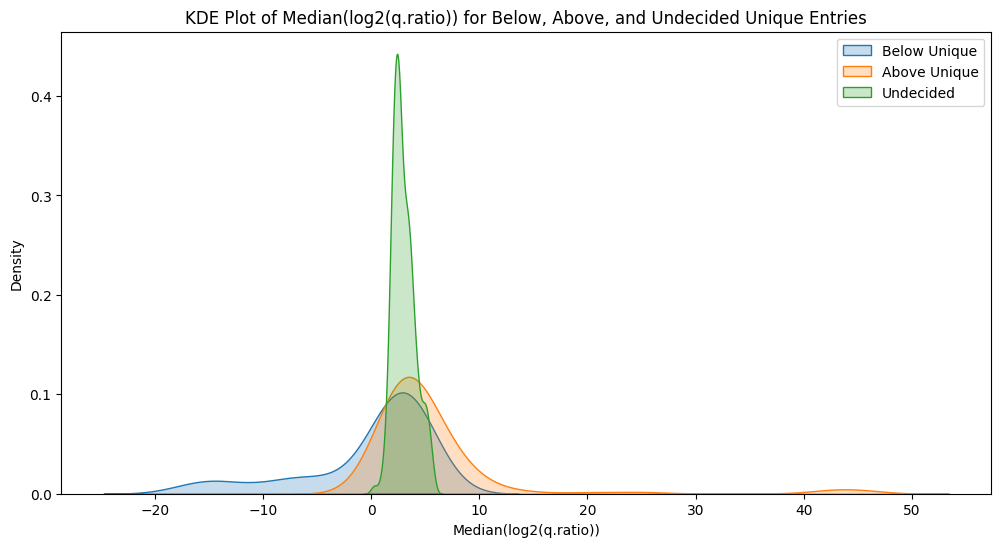

In [19]:
plot_kde_datasets(lmcd1_full, fl_below_unique, fl_above_unique, fl_undecided)